In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as sched
from torch.utils.data import WeightedRandomSampler

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
import numpy as np
import pickle
from random import randint

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

### Parameters

In [3]:
batch_size = 1000

num_classes = 43
in_channels = 3

epoch = 5
weight_decay = 1e-6
lr = 5e-5

difusion_steps = 100

### Transforms

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

reverse_transform = transforms.Lambda(lambda t: (t + 1.05) / 2) # used to denormalize

### Dataset

In [7]:
full_DS = ImageFolder(root="trafic_32", transform=transform)
full_loader = DataLoader(dataset=full_DS, pin_memory=True, num_workers=0, shuffle=True, batch_size=batch_size)

len(full_DS)

39209

In [6]:
# classes_elem_cnt = {}
# for i in range(len(full_DS)):

#     x = full_DS[i][1]

#     if (x in classes_elem_cnt.keys()):
#         classes_elem_cnt[x] += 1

#     else:
#         classes_elem_cnt[x] = 1

#     # if (i%10==0):
# print(classes_elem_cnt)

# with open('classes_member_cnt.pkl', 'wb') as file:
#     pickle.dump(classes_elem_cnt, file)


### Model + U-Net block

In [8]:
class Unet_Block(nn.Module):
    """
    Base U-Net block
    in_channels - number of input channels
    out_channels - number of out channels
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.activation = nn.SiLU()

        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=(1,1)),
            self.activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=(1,1)),
            self.activation,
            nn.BatchNorm2d(out_channels) # to moze na GN zmienic
        ])

    def forward(self, x):

        for layer in self.layers:
            x = layer(x)

        return x

In [9]:
class Rescaler(nn.Module):
    """
    Resacler; either upscales given input or downscales it (size x2 or /2 only)
    """

    def __init__(self, in_channels, out_channels, upscale:bool):
        super().__init__()

        if upscale:
            self.rescaler = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=(2,2))
        else:
            self.rescaler = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=(2,2))

    def forward(self, x):
        return self.rescaler(x)

In [10]:
class U_Net(nn.Module):

    def __init__(self, in_channels, num_classes, embedding_classes_dim, embedding_noise_dim):
        super().__init__()

        self.num_classes = num_classes
        self.embedding_dim = embedding_classes_dim
        self.class_embedding = nn.Embedding(num_classes, embedding_classes_dim) #

        self.embedding_noise_dim = embedding_noise_dim
        self.embedding_noise = nn.Linear(1, embedding_noise_dim) # linear, bo noise_level sa z przestrzeni ciągłej -1,1 --> inf num classes

        self.encoder = nn.ModuleList([

            Unet_Block(in_channels, 32),
            Rescaler(32, 32, upscale=False), # 16x16

            Unet_Block(32, 64),
            Rescaler(64, 64, upscale=False), #8x8

            Unet_Block(64, 128),
            Rescaler(128, 128, upscale=False), #4x4

            Unet_Block(128, 172),
            Rescaler(172, 172, upscale=False), # 2x2
        ])

        self.latent = nn.Sequential(
            nn.Conv2d(in_channels=172, out_channels=236, kernel_size=3, padding=1, stride=1),
            nn.SiLU(),
            nn.Conv2d(in_channels=236, out_channels=236, kernel_size=3, padding=1, stride=1),
            nn.SiLU(),
            nn.BatchNorm2d(236)
        )

        self.decoder = nn.ModuleList([

            Rescaler(236+embedding_classes_dim+embedding_noise_dim, 236+embedding_classes_dim+embedding_noise_dim, upscale=True), # 4x4
            Unet_Block(408+embedding_classes_dim+embedding_noise_dim, 172), # 236 + 172(res)

            Rescaler(172, 172, upscale=True), #8x8
            Unet_Block(300, 128), #(172 + 128)

            Rescaler(128, 128, upscale=True), #16x16
            Unet_Block(192, 64), #(128 + 64)

            Rescaler(64, 64, upscale=True), # 32x32
            Unet_Block(96, 32), #(64 + 32)

            nn.Conv2d(in_channels=32, out_channels=in_channels, kernel_size=1, stride=1, padding=0)

        ])

    def forward(self, x, class_label, noise_amount):
        residual = []

        # encoder
        for idx, layer in enumerate(self.encoder):
            x = layer(x)

            if(idx%2 == 0):
                residual.append(x)
        residual.reverse()

        # latent
        x = self.latent(x)

        # class conditioning + noise conditioning``
        class_embedding = self.class_embedding(class_label).unsqueeze(2).unsqueeze(3)
        class_embedding = class_embedding.expand(-1, -1, x.shape[2], x.shape[3])

        noise_embedding = self.embedding_noise(noise_amount.view(-1, 1)).unsqueeze(2).unsqueeze(3)
        noise_embedding = noise_embedding.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, class_embedding, noise_embedding], dim=1)

        # decoder
        for idx, layer in enumerate(self.decoder):
            x = layer(x)

            if(idx%2 == 0 and idx <= 6): # idx<=6, bo na idx=8 jest convm, ktory nie dostaje rezyduala
                x = torch.cat([x, residual[int(idx/2)]], dim=1) # (B, CH, H, W) - dim=1

        return x

In [25]:
model = U_Net(in_channels, num_classes, 60, 5)
model.to(device)
model.load_state_dict(torch.load("Diffusion_140epoch.pt"))

<All keys matched successfully>

In [12]:
params_sum = 0
for params in model.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

4068262

In [13]:
optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay, lr=lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.997)
loss_fn = nn.MSELoss()

### Image corrupting fnc

In [14]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.randn_like(x) # to zmienic na randn_like - rozkłąd gaussa + dodac resize obrazkó do -1,1
    amount = amount.view(-1, 1, 1, 1)  # Ensure shape compatibility for broadcasting
    return x * (1 - amount) + noise * amount


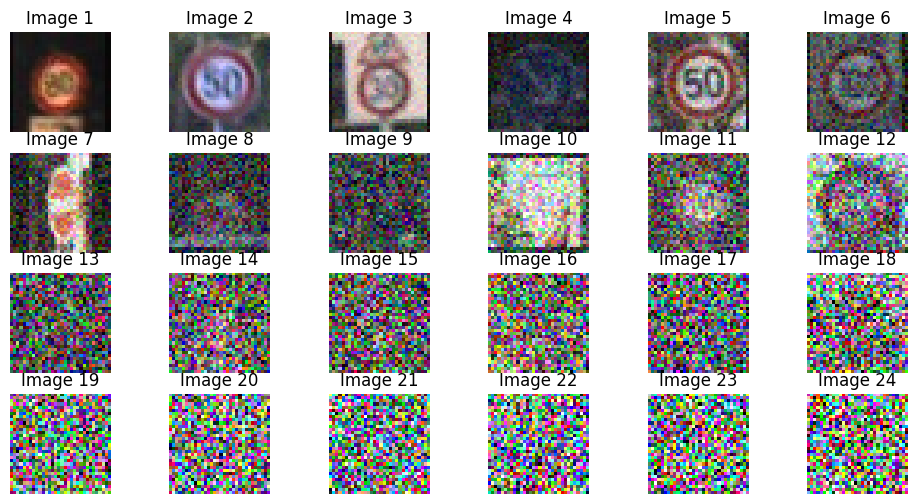

In [15]:
img, y = next(iter(full_loader))
img = img[:24, :,:,:]
x=img

amount = torch.linspace(0, 1, x.shape[0])
x = corrupt(x, amount)
x = reverse_transform(x)
x = x.detach().cpu().numpy()

fig, axes = plt.subplots(4, 6, figsize=(12, 6))
for i in range(4):
    for j in range(6):
        index = i * 6 + j
        axes[i, j].imshow(x[index].transpose(1, 2, 0).clip(0, 1))
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Image {index + 1}')

plt.show()

### Train function

In [16]:
def train(model, loader, epoch):
    model.train()
    losses = []

    for epoch in range(epoch):

        for x, y in loader:

            x = x.to(device)
            y = y.to(device)

            noise_amount = torch.rand(x.shape[0]).to(device)
            noisy_x = corrupt(x, noise_amount)

            # Get the model prediction
            pred = model(noisy_x, y, noise_amount)

            # Calculate the loss
            loss = loss_fn(pred, x)

            # Backprop and update the params:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(full_loader) :]) / len(full_loader)
        print(f"Finished epoch {epoch+1}. Average loss for this epoch: {avg_loss:05f}")
        torch.save(model.state_dict(), f=f'magnum_opus_podejscie_2_DOTRENOWYWANIE/U_net_test_{epoch}.pt')

    model.eval()
    return losses

In [17]:
# losses = train(model, full_loader, epoch)

### Learning curve

(0.0, 0.5)

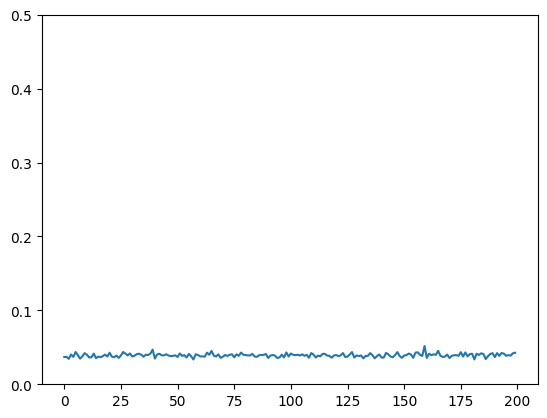

In [ ]:
plt.plot(losses)
plt.ylim(0, 0.5)

### Model predictions (Model is predicting fully-denoised image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


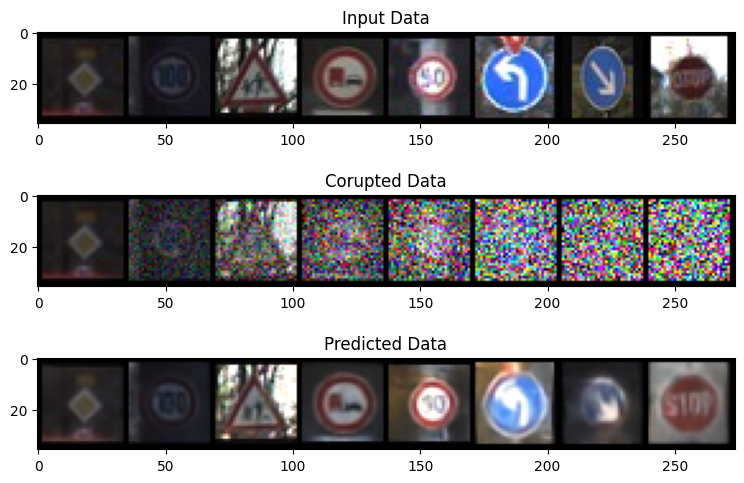

In [42]:
img, y = next(iter(full_loader))
x = img[:8, :,:,:]
img_classes = y[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)
noised_x = noised_x.detach().cpu()

with torch.no_grad():
    preds = model(noised_x.to(device), img_classes.to(device), amount.to(device)).detach().cpu()

x = reverse_transform(x)
noised_x = reverse_transform(noised_x)
preds = reverse_transform(preds)

fig, axs = plt.subplots(3, 1, figsize=(9, 6))
axs[0].set_title("Input Data")
axs[0].imshow(torchvision.utils.make_grid(x, nrow=8, padding=2).permute(1, 2, 0))

axs[1].set_title("Corupted Data")
axs[1].imshow(torchvision.utils.make_grid(noised_x, nrow=8, padding=2).permute(1, 2, 0))

axs[2].set_title("Predicted Data")
axs[2].imshow(torchvision.utils.make_grid(preds, nrow=8, padding=2).permute(1, 2, 0))

plt.show()

### Difusion

In [27]:
def difusion(steps, image_num, class_labels):

    x = torch.randn(image_num, 3, 32, 32).to(device)
    pred_output_history = []
    step_history = [x.detach().cpu()]

    classes_idx = torch.tensor(class_labels).to(device)
    mix_factor = torch.zeros(image_num).to(device)

    for step in range(steps):
        with torch.no_grad():
            pred = model(x, classes_idx, 1-mix_factor)

        # mix_factor - "amount" of predicted image passed to next iter
        mix_factor = torch.tensor([1/(steps - step)]).to(device)

        pred_output_history.append(pred.detach().cpu())
        x = x*(1-mix_factor) + pred*mix_factor
        mix_factor = torch.ones(image_num).to(device) * mix_factor
        step_history.append(x.detach().cpu())

    return x, pred_output_history, step_history

In [33]:
image_num = 8
class_labels = [randint(0, num_classes-1) for _ in range(0, image_num) ]
x, pred_output_history, step_history = difusion(difusion_steps, image_num, class_labels)

In [34]:
fig, axs = plt.subplots(6, 2, figsize=(100, 100))
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')

j=0
for i in range(difusion_steps):
    if (i%int(difusion_steps/5) == 0):
        axs[j, 0].imshow(torchvision.utils.make_grid(reverse_transform(step_history[i]), padding=2).permute(1, 2, 0))
        axs[j, 1].imshow(torchvision.utils.make_grid(reverse_transform(pred_output_history[i]), padding=2).permute(1, 2, 0))
        j+=1

axs[5, 0].imshow(torchvision.utils.make_grid(reverse_transform(step_history[difusion_steps-1]), padding=2).permute(1, 2, 0))
axs[5, 1].imshow(torchvision.utils.make_grid(reverse_transform(pred_output_history[difusion_steps-1]), padding=2).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

### Predictions considerng data distribution in DS

In [99]:
def generate_weighted_indices(member_counts, batch_size):
    # Convert member counts to weights
    weights = member_counts

    # Create a weighted sampler
    sampler = WeightedRandomSampler(weights, num_samples=batch_size, replacement=True)

    # Generate indices
    indices = list(sampler)

    return indices

### Final generation

In [102]:
with open('classes_member_cnt.pkl', 'rb') as file:
    classes_numerosity = pickle.load(file)


In [ ]:
batch_size = 1000
member_counts = [x for x in classes_numerosity.values()]

indices = generate_weighted_indices(member_counts, batch_size=batch_size)
x, pred_output_history, step_history = difusion(difusion_steps, batch_size, indices)

x = reverse_transform(x)
print(x.shape)

In [111]:
torch.save(x.detach().cpu(), f="piątek_Pobocha_Sendybył.pt")